## Goals of Linear Regression
Linear regression is powerful technique that is often used to understand whether and how certain *predictor variables* (e.g., garage size, year built, etc.) in a dataset (linearly) relate to some *target variable* (e.g., sale prices). By modeling these relationships in the housing data, we can:

1. **Explain**: Use *statistics* to make scientific claims concerning which predictor variables have the greatest impact on sale price — the target variable 
2. **Predict**: Use *predictive modeling* to predict hypothetical/future sale prices based on observed values of the predictor variables in our dataset (e.g., garage size, year built, etc.). 

In this workshop, we will explore how we can exploit well-established machine learning methods, including "multivariate regression" and "regularization techniques" (more on these terms later), to achieve both of the above goals. 

# EXERCISE_START: To predict or explain. That is the question.
When trying to model data you use in your work, which goal is typically more prevalent? Do you typically care more about (1) accurately predicting some target variable or (2) making scientific claims concerning the existence of certain relationships between variables?
# EXERCISE_SOLUTION
In a research setting, goal #1 (explain) typically takes higher priority over goal #2 (predict) since explainations hold high value in science, but both goals are sometimes relevant. In industry, the reverse is typically true as many industry applications place predictive accuracy above explainability. We will explore how these goals align and sometimes diverge from one another throughout this lesson.
# EXERCISE_END

## Univariate linear regression
Before we turn our attention towards modeling high-dimensional datasets, let's first review a few basic concepts from univariate linear modeling. The classic equation for a univariate linear regression model is shown below.

$$y = mx + b$$

where...

* $y$ = observed values of the target variable / dependent variable / response variable
* $x$ = observed values of the predictor variable / model feature / independent variable / explanatory variable
* $m$ = regression slope / predictor coefficient
* $b$ = y-intercept

**Note**: It is common in the field of machine learning — which is itself a combination of several fields (math, statistics, computer science) — to use multiple terms interchangeably for a given concept. Note the above synonyms for the target and predictor variable terms — you'll encounter these synonyms across other readings and materials.


### Predicting housing prices
Given the Ames housing dataset, let's first review how we can use univariate models to predict housing sale prices. We'll unpack techniques to *explain* univariate models in the next episode (**spoiler alert**: statistics are your friend).

We'll start by loading in the Ames housing data as we have done previously in this workshop.

In [1]:
# See here for thorough documentation regarding the feature set: 
# https://www.openml.org/d/42165
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)

##### Reminder of basic data properties
1. How many observations and features are there in the data? 
2. What are some of the features available?
3. What is the name of the target feature?

In [2]:
print(f"housing['data'].shape = {housing['data'].shape}\n") # 80 features total, 1460 observations
print(f"housing['feature_names'] = {housing['feature_names']}\n")
print(f"housing['target_names'] = {housing['target_names']}\n")

housing['data'].shape = (1460, 80)

housing['feature_names'] = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'E

#### 2) Extract predictor variable and target variable from dataframe
Next, we'll extract the two variables we'll use for our model — the target variable that we'll attempt to predict (SalePrice), and a sinlge predictor variable that will be used to predict the target variable. For this example, we'll explore how well the "YearBuilt" variable (i.e., the predictor variable) can predict sale prices. 

In [3]:
# Extract x (single predictor variable = YearBuilt) and y (target variable = SalePrice)
y=housing['target']
x=housing['data']['YearBuilt']

#### 3) Train/test split
Next, we will prepare two subsets of our data to be used for "model-fitting" and "model evaluation". 

During the model-fitting step, we use a subset of the data referred to as **training data** to estimate the model's coefficients. The univariate model will find a line of best fit through this data. 

Next, we can assess the model's ability to generalize to new datasets by measuring its performance on the remaining, unseen data. This subset of data is referred to as the **test data** or holdout set. By evaluating the model on the test set, which was not used during training, we can obtain an unbiased estimate of its performance.

If we were to evaluate the model solely on the training data, it could lead to **overfitting**. Overfitting occurs when the model learns the noise and specific patterns of the training data too well, resulting in poor performance on new data. By using a separate test set, we can identify if the model has overfit the training data and assess its ability to generalize to unseen samples.

While overfitting is typically not likely to occur when using only a single predictor variable, it is still a good idea to use a train/test split when fitting univariate models. This can help in detected unanticipated issues with the data, such as missing values, outliers, or other anomalies that affect the model's behavior.

![The above image is from Badillo et al., 2020. An Introduction to Machine Learning. Clinical Pharmacology & Therapeutics. 107. 10.1002/cpt.1796.](../fig/regression/under_v_over_fit.png)


When determinining what percentage of data to leave out as the test set, it is important to balance the following opposing forces:
* as training dataset size increases, the model has more data to learn from and can typically generalize better
* as test dataset size increases, you can gain a better assessment of the model's ability to generalize

Typically, you want to leave out just enough test data so that your estimate of model performance isn't skewed by having too few observations in the test set. A good rule of thumb is to reserve 1/3 of the full dataset for testing, but you may want to lower this percentage if you do not have many samples to begin with (i.e., save more data for training the model).

The below code will split our dataset into a training dataset containing 2/3 of the samples, and a test set containing the remaining 1/3 of the data.

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# reshape single-var predictor matrix in preparation for model-fitting step (requires single column vectors to have 1 column rather than zero)
x_train=x_train.values.reshape(-1,1)
x_test=x_test.values.reshape(-1,1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

print(type(y_train))
print(type(x_train))

(978, 1)
(482, 1)
(978,)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


#### 4) Fit the model to the training dataset

In [5]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train,y_train)

#### 5) Get model predictions for train and test data

In [6]:
y_pred_train=reg.predict(x_train)
y_pred_test=reg.predict(x_test)

#### 6) Plot the data vs predictions - qualitative assessment


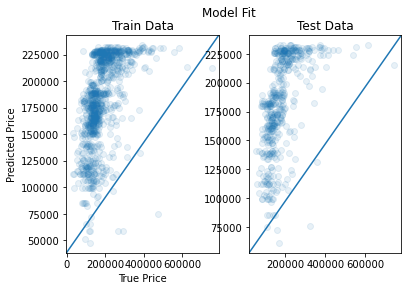

In [7]:
from helper_functions import plot_model_predictions 
plot_model_predictions(y_train, y_pred_train, 
                       y_test, y_pred_test)

#### 5) Measure model error and assess under/overfitting
**Root Mean Squared Error (RMSE)**:
The RMSE provides an easy-to-interpret number that represents error in terms of the units of the target variable. With our univariate model, the "YearBuilt" predictor variable (a.k.a. model feature) predicts sale prices within +/- $68,106 from the true sale price. We always use the RMSE of the test set to assess the model's ability to generalize on unseen data. An extremely low prediction error in the train set is also a good indicator of overfitting.

Train RMSE = 67500.86657586123
Test RMSE = 68106.22257848026


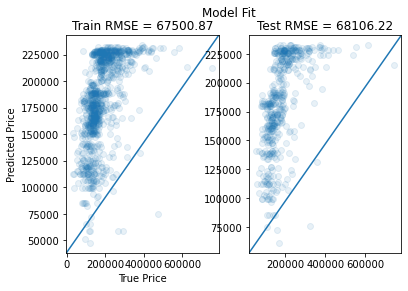

In [10]:
from sklearn import metrics

RMSE_train = metrics.mean_squared_error(y_train,y_pred_train,squared=False) 
RMSE_test = metrics.mean_squared_error(y_test,y_pred_test,squared=False) 

print(f"Train RMSE = {RMSE_train}")
print(f"Test RMSE = {RMSE_test}")

plot_model_predictions(y_train, y_pred_train, 
                       y_test, y_pred_test,
                      'RMSE', train_err=RMSE_train, test_err=RMSE_test)

Here, both train and test RMSE are very similar to one another. As expected with most univariate models, we do not see any evidence of overfitting. However, we do see that our model is perhaps underfitting given its poor ability to predict any of the true housing prices.

**Mean Absolute Percentage Error**:
What if we wanted to know the percent difference between the true sale price and the predicted sale price? For this, we can use the **mean absolute percentage error (MAPE)**...

In [12]:
MAPE_train = metrics.mean_absolute_percentage_error(y_train, y_pred_train) 
MAPE_test = metrics.mean_absolute_percentage_error(y_test, y_pred_test) 
print(f"Train MAPE = {MAPE_train}")
print(f"Test MAPE = {MAPE_test}")

Train MAPE = 0.2869562321419441
Test MAPE = 0.2705162463887326


With the MAPE measurement (max value of 1 which corresponds to 100%), we can state that our model over/under estimates sale prices by an average of 27.1% (28.7%) across all houses included in the test set (train set). Certainly seems there is room for improvement based on this measure.

**R-Squared**: Another useful error measurement to use with regression models is the coefficient of determination — $R^2$. Oftentimes pronounced simply "R-squared",  this measure assesses the proportion of the variation in the target variable that is predictable from the predictor variable(s). Using sklearn's metrics, we can calculate this as follows:

In [13]:
R2_train = metrics.r2_score(y_train, y_pred_train) 
R2_test = metrics.r2_score(y_test, y_pred_test) 
print(f"Train R-squared = {MAPE_train}")
print(f"Test R-squared = {MAPE_test}")


Train R-squared = 0.2869562321419441
Test R-squared = 0.2705162463887326


Our model predicts 27.1% (28.7%) of the variance across sale prices in the test set (train set).

To read more about additional error/loss measurements, visit [sklearn's metrics documentation](https://scikit-learn.org/stable/modules/model_evaluation.html).

# EXERCISE_START: More on R-squared
Some of the below is paraphrased from (make sure to go back and rephrase in own words -- use different examples at least): https://www.statology.org/good-r-squared-value
 
R-squared is a measure of how well a linear regression model “fits” a dataset (i.e., the proportion of the variance in the response variable that can be explained by the predictor variable(s)).

The value for R-squared can range from 0 to 1. A value of 0 indicates that the response variable cannot be explained by the predictor variable at all. A value of 1 indicates that the response variable can be perfectly explained without error by the predictor variable. In practice, you will likely never see a value of 0 or 1 for R-squared. Instead, you’ll likely encounter some value between 0 and 1. ""

Our above example model is able to explain roughly 27% of the variance in the test dataset. Is this a “good” value for R-squared?

**Hint**: The answer to this question depends on your objective for the regression model. This relates back to the two tangentially related goals of *explaining* vs *predicting*, namely:
    
1. Are you interested in *explaining* the relationship between the predictor(s) and the response variable?

OR

2. Are you interested in *predicting* the response variable?

Depending on the objective, the answer to "What is a good value for R-squared?" will be different.

# EXERCISE_SOLUTION
#### Explaining the Relationship Between the Predictor(s) and the Response Variable
If your main objective for your regression model is to explain the relationship(s) between the predictor(s) and the response variable, the R-squared is mostly irrelevant. A predictor variable that consistently relates to a change in the response variable is typically always interesting — regardless of the the effect size. 

For example, suppose in the regression example from above, you see that the coefficient  for the predictor YearBuilt is 100 and that it's statistically significant. This means that an increase of one in YearBuilt  is associated with an average increase of \$100 dollars in final sale price. 

Whether the R-squared value for this regression model is 0.2 or 0.9 doesn’t change this interpretation. Since you are simply interested in the relationship between YearBuilt and final sale price, you don't have to be overly concerned with the R-square value of the model.

#### Predicting the Response Variable
If your main objective is to predict the value of the response variable accurately using the predictor variable, then R-squared is important.

In general, the larger the R-squared value, the more precisely the predictor variables are able to predict the value of the response variable.

How high an R-squared value needs to be depends on how precise you need to be. For example, in scientific studies, the R-squared may need to be above 0.95 for a regression model to be considered reliable. In other domains, an R-squared of just 0.3 may be sufficient if there is extreme variability in the dataset.

To find out what is considered a “good” R-squared value, you will need to explore what R-squared values are generally accepted in your particular field of study.

# EXERCISE_END

#### 7) Explaining Model Predictions Using Statistics 
At this point, we have assessed the predictive accuracy of our model. However, what if we want to make scientific claims regarding how impactful the 'YearBuilt' predictor variable really is on sale prices? For this kind of question, we need to incorporate statistical analyses after fitting our model. This next section will explore the assumptions required for running basic statistics on a linear regression model.